In [67]:
import pandas as pd 
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.inspection import permutation_importance
import lightgbm as lgb
import shap
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error, accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.metrics import accuracy_score, f1_score,roc_auc_score,precision_score, recall_score

import numpy as np


from sklearn.datasets import load_breast_cancer
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import *
# from imblearn.metrics import specificity_score
import pandas as pd
import missingno as msno
from sklearn.model_selection import train_test_split
from missforest import MissForest
from sklearn.ensemble import IsolationForest
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from sklearn.inspection import permutation_importance
from xgboost import XGBRegressor, XGBClassifier
import shap
import lightgbm as lgb
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from lazypredict.Supervised import LazyRegressor, LazyClassifier
from scipy.stats import randint, uniform, zscore, stats
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_percentage_error, accuracy_score, classification_report, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import TargetEncoder
from sklearn import linear_model
from sklearn.linear_model import Lasso, LogisticRegression, LinearRegression
from statsmodels.tools.tools import add_constant
from sklearn.preprocessing import OneHotEncoder, RobustScaler
import statsmodels.api as sm
from sklearn.ensemble import StackingRegressor
from sklearn.svm import SVR
from sklearn.ensemble import VotingRegressor
from sklearn.compose import ColumnTransformer
import joblib

In [68]:
df = pd.read_csv("/workspaces/carlossuesc95-intro-ml/data/raw/internal-link tree.csv")
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.60,0.63,50,1
1,1,85,66,29,0,26.60,0.35,31,0
2,8,183,64,0,0,23.30,0.67,32,1
3,1,89,66,23,94,28.10,0.17,21,0
4,0,137,40,35,168,43.10,2.29,33,1


In [69]:
df_cop = df.copy()
vars_cero = ['Insulin', 'BloodPressure', 'BMI', 'Glucose']
df_cop[vars_cero] = df_cop[vars_cero].replace(0, np.nan)

## Train Test Split 

In [70]:
X = df_cop.drop('Outcome',axis=1)
y = df_cop['Outcome']

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Imputacion

In [72]:
imputer = MissForest()

X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)
X_train_imp

  0%|          | 0/5 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:00<00:00, 23.57it/s]


,Pregnancies,SkinThickness,DiabetesPedigreeFunction,Age,Glucose,BMI,BloodPressure,Insulin
60,2,0,0.30,21,84.00,28.24,69.85,111.18
618,9,24,1.28,50,112.00,28.20,82.00,169.58
346,1,19,0.65,22,139.00,28.70,46.00,83.00
294,0,0,0.25,65,161.00,21.90,50.00,240.72
231,6,37,0.24,46,134.00,46.20,80.00,370.00
...,...,...,...,...,...,...,...,...
71,5,35,0.41,26,139.00,28.60,64.00,140.00
106,1,0,0.21,27,96.00,22.40,122.00,98.70
270,10,37,1.14,38,101.00,45.60,86.00,119.07
435,0,0,0.20,29,141.00,42.40,73.71,117.73


## Seleccion de caracteristicas

### metodo 1

In [73]:
model = RandomForestClassifier(n_estimators=100,random_state=42,n_jobs=-1).fit(X_train_imp,y_train)
# Importancia de características
importances = model.feature_importances_/model.feature_importances_.sum()*100

#Convertir a dataframe
df_rf_imp = pd.DataFrame({'feature': X_train.columns,'rf_importance': importances}).sort_values(by='rf_importance', ascending=False)

#importancia acumulada
df_rf_imp['rf_importance_accum'] = df_rf_imp['rf_importance'].cumsum()

df_rf_imp

,feature,rf_importance,rf_importance_accum
4,Insulin,22.42,22.42
7,Age,15.93,38.35
5,BMI,15.18,53.53
3,SkinThickness,13.51,67.04
2,BloodPressure,11.03,78.06
6,DiabetesPedigreeFunction,7.78,85.85
0,Pregnancies,7.26,93.11
1,Glucose,6.89,100.00


### metodo 2

In [74]:
#XGBClassifier

#crear conjunto de val
X_train1, X_val, y_train1, y_val = train_test_split(X_train_imp,y_train, test_size=0.2,random_state=42)

#ajustar modelo

model_xgb = XGBClassifier(objective='binary:logistic',random_state=42).fit(X_train1,y_train1)

#### 10 permutaciones por caracteristica

In [75]:
perm = permutation_importance(model_xgb,X_val,y_val,n_repeats=10,random_state=42,n_jobs=-1,scoring='recall')
df_perm_imp = pd.DataFrame({'feature': X_train.columns, 'perm_imp': perm.importances_mean*100}).sort_values('perm_imp', ascending=False)
df_perm_imp

,feature,perm_imp
4,Insulin,16.67
5,BMI,5.00
3,SkinThickness,4.76
0,Pregnancies,3.10
1,Glucose,2.38
7,Age,1.90
2,BloodPressure,1.19
6,DiabetesPedigreeFunction,0.48


### metodo 3

In [76]:

#METODO 3: usar SHAP

model_lgbm = lgb.LGBMClassifier(random_state=42,n_jobs=-1).fit(X_train1,y_train1)

explainer = shap.Explainer(model_lgbm,X_val)
shap_vals = explainer(X_val,check_additivity=False).values

imp_shap = np.abs(shap_vals).mean(axis=0)
imp_shap_pct = imp_shap/imp_shap.sum()*100
df_shap_imp = pd.DataFrame({"feature": X_val.columns, "shap_imp": imp_shap_pct}).sort_values('shap_imp', ascending=False)
df_shap_imp

,feature,shap_imp
4,Glucose,25.72
3,Age,16.64
5,BMI,15.43
7,Insulin,12.48
2,DiabetesPedigreeFunction,11.16
6,BloodPressure,8.77
1,SkinThickness,5.54
0,Pregnancies,4.26


In [77]:
df_importances = (
    df_rf_imp
    .merge(df_perm_imp, on='feature', how='outer')
    .merge(df_shap_imp, on='feature', how='outer')
).sort_values('rf_importance', ascending=False)
df_importances

,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
5,Insulin,22.42,22.42,16.67,12.48
0,Age,15.93,38.35,1.90,16.64
1,BMI,15.18,53.53,5.00,15.43
7,SkinThickness,13.51,67.04,4.76,5.54
2,BloodPressure,11.03,78.06,1.19,8.77
3,DiabetesPedigreeFunction,7.78,85.85,0.48,11.16
6,Pregnancies,7.26,93.11,3.10,4.26
4,Glucose,6.89,100.00,2.38,25.72


In [78]:
df_filt = df_importances[(df_importances['rf_importance']>=1)&(df_importances['perm_imp']>=1)&(df_importances['shap_imp']>=1)]
df_filt

,feature,rf_importance,rf_importance_accum,perm_imp,shap_imp
5,Insulin,22.42,22.42,16.67,12.48
0,Age,15.93,38.35,1.90,16.64
1,BMI,15.18,53.53,5.00,15.43
7,SkinThickness,13.51,67.04,4.76,5.54
2,BloodPressure,11.03,78.06,1.19,8.77
6,Pregnancies,7.26,93.11,3.10,4.26
4,Glucose,6.89,100.00,2.38,25.72


In [79]:
features = df_filt['feature']
features

5          Insulin
0              Age
1              BMI
7    SkinThickness
2    BloodPressure
6      Pregnancies
4          Glucose
Name: feature, dtype: object

In [80]:
X_train_sel = X_train_imp[features]
X_test_sel = X_test_imp[features]

## RF

#### simple

In [81]:

random_forest_simple = RandomForestClassifier(n_estimators=5,max_depth=2,min_samples_leaf=20,random_state=42)
random_forest_simple.fit(X_train_sel,y_train)

,n_estimators,5
,criterion,'gini'
,max_depth,2
,min_samples_split,2
,min_samples_leaf,20
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [82]:
#V1: evaluacion del modelo en entrenamiento y prueba
train_pred = random_forest_simple.predict(X_train_sel)
test_pred= random_forest_simple.predict(X_test_sel)

#### complejo

In [83]:
random_forest_complejo = RandomForestClassifier(n_estimators=100,max_depth=20,min_samples_leaf=1,random_state=42)
random_forest_complejo.fit(X_train_sel,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [84]:
train_pred2 = random_forest_complejo.predict(X_train_sel)
test_pred2= random_forest_complejo.predict(X_test_sel)

In [85]:
def get_metrics(y_train, y_test, y_pred_train, y_pred_test):
    # Calcular métricas para el conjunto de entrenamiento
    train_accuracy = accuracy_score(y_train, y_pred_train)
    train_f1 = f1_score(y_train, y_pred_train)
    train_auc = roc_auc_score(y_train, y_pred_train)
    train_precision = precision_score(y_train, y_pred_train)
    train_recall = recall_score(y_train, y_pred_train)
    #train_specificity = specificity_score(y_train, y_pred_train)

    # Calcular métricas para el conjunto de prueba
    test_accuracy = accuracy_score(y_test, y_pred_test)
    test_f1 = f1_score(y_test, y_pred_test)
    test_auc = roc_auc_score(y_test, y_pred_test)
    test_precision = precision_score(y_test, y_pred_test)
    test_recall = recall_score(y_test, y_pred_test)
    #test_specificity = specificity_score(y_test, y_pred_test)

    # Calcular la diferencia entre métricas de entrenamiento y prueba
    diff_accuracy = train_accuracy - test_accuracy
    diff_f1 = train_f1 - test_f1
    diff_auc = train_auc - test_auc
    diff_precision = train_precision - test_precision
    diff_recall = train_recall - test_recall
    #diff_specificity = train_specificity - test_specificity

    # Crear un DataFrame con los resultados
    metrics_df = pd.DataFrame([[train_accuracy, train_f1, train_auc, train_precision, train_recall,],[test_accuracy, test_f1, test_auc, test_precision, test_recall],[diff_accuracy, diff_f1, diff_auc, diff_precision, diff_recall,]],
                              columns = ['Accuracy', 'F1', 'AUC', 'Precision', 'Recall'],
                              index = ['Train','Test', 'Diferencia'])

    return metrics_df

In [86]:
get_metrics(y_train,y_test,train_pred,test_pred)

,Accuracy,F1,AUC,Precision,Recall
Train,0.76,0.55,0.68,0.80,0.42
Test,0.77,0.61,0.71,0.76,0.51
Diferencia,-0.00,-0.06,-0.03,0.05,-0.09


In [87]:
get_metrics(y_train,y_test,train_pred2,test_pred2)

,Accuracy,F1,AUC,Precision,Recall
Train,1.00,1.00,1.00,1.00,1.00
Test,0.73,0.62,0.71,0.61,0.64
Diferencia,0.27,0.38,0.29,0.39,0.36


### matriz pred-simple

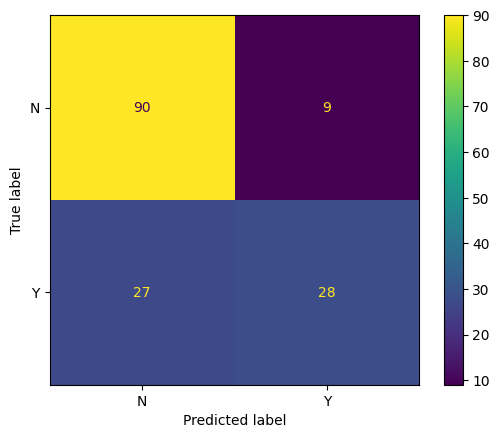

In [88]:
cm = confusion_matrix(y_test, test_pred)
cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'Y'])
disp.plot()

### matriz pred-complejo

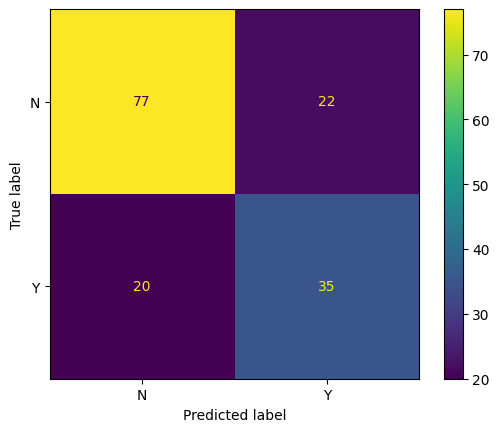

In [89]:
cm = confusion_matrix(y_test, test_pred2)
cm

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['N', 'Y'])
disp.plot()

In [90]:
joblib.dump(random_forest_complejo,'random_fts_diabetes.pkl')

['random_fts_diabetes.pkl']